<a href="https://colab.research.google.com/github/an0308x/Flow-Matching/blob/main/Rectified_Flow_Matching_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -q torchdiffeq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 975.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.4 MB/s eta 0:00:00


--- Starting Initial Flow Training ---
Epoch 0, Loss: 1.6988
Epoch 1000, Loss: 0.9403
Epoch 2000, Loss: 0.9516
Epoch 3000, Loss: 0.9205
Epoch 4000, Loss: 1.0750
--- Initial Flow Training Finished ---

--- Generating Rectified Training Pairs ---
Rectified pairs (z0, z1) created.
--- Starting Rectified Flow Training ---
Epoch 0, Loss: 0.3561
Epoch 1000, Loss: 0.0036
Epoch 2000, Loss: 0.0012
Epoch 3000, Loss: 0.0005
Epoch 4000, Loss: 0.0005
--- Rectified Flow Training Finished ---


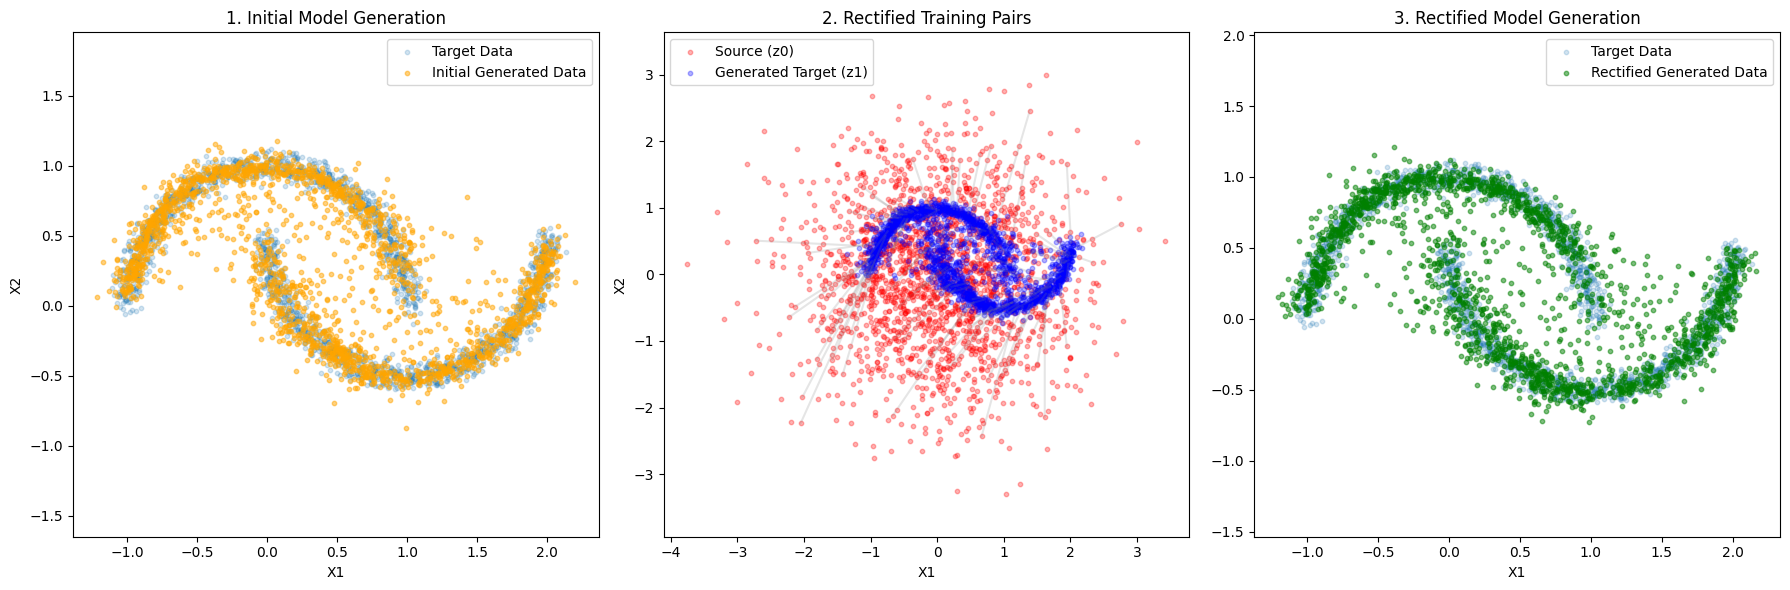

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torchdiffeq import odeint
import numpy as np

# --- 1. Setup and Data ---
# The same setup as before.
X, _ = make_moons(n_samples=2000, noise=0.05)
target_data = torch.tensor(X, dtype=torch.float32)

# --- 2. The Neural Network (Vector Field) ---
# The model architecture remains unchanged.
class VectorField(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        t_vec = t.expand(x.size(0), 1)
        xt = torch.cat([x, t_vec], dim=1)
        return self.network(xt)

# --- 3. The Flow Matching Loss ---
# The loss function is also identical.
def flow_matching_loss(model, x1, x0=None):
    if x0 is None:
        x0 = torch.randn_like(x1)
    t = torch.rand(x1.size(0), 1)
    xt = (1 - t) * x0 + t * x1
    ut = x1 - x0
    vt = model(xt, t)
    return torch.mean((vt - ut)**2)

# --- 4. The Training Loop ---
# We modify the training loop slightly to handle the rectified flow case
# where we provide both x0 and x1.
def train_model(model, x1_data, x0_data=None, epochs=5000, batch_size=256, lr=1e-3, title="Training"):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"--- Starting {title} ---")
    for epoch in range(epochs):
        optimizer.zero_grad()

        indices = torch.randint(0, len(x1_data), (batch_size,))
        x1_batch = x1_data[indices]

        # If x0_data is provided (for rectified flow), use the corresponding samples.
        # Otherwise (for initial flow), sample random noise.
        x0_batch = x0_data[indices] if x0_data is not None else None

        loss = flow_matching_loss(model, x1_batch, x0=x0_batch)
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    print(f"--- {title} Finished ---")

# --- 5. Generation (Inference) ---
# The generation function is also identical.
def generate_samples(model, num_samples=1000):
    model.eval()
    with torch.no_grad():
        x0 = torch.randn(num_samples, 2)
        def ode_func(t, x):
            t_tensor = torch.full((x.size(0), 1), t.item())
            return model(x, t_tensor)
        t_span = torch.tensor([0.0, 1.0])
        generated_x = odeint(ode_func, x0, t_span, method='dopri5')[-1]
    return generated_x.cpu().numpy()


# --- Main Execution ---
if __name__ == '__main__':
    # --- STEP 1: Train the initial Flow Matching model ---
    initial_model = VectorField()
    train_model(initial_model, target_data, epochs=5000, title="Initial Flow Training")

    # Generate samples from the initial model for visualization
    initial_generated_data = generate_samples(initial_model, num_samples=2000)

    # --- STEP 2: The "Reflow" procedure to get rectified pairs ---
    print("\n--- Generating Rectified Training Pairs ---")
    # Start with a new set of noise
    z0 = torch.randn_like(target_data)
    # Generate the corresponding "data" using the initial model
    with torch.no_grad():
        def ode_func(t, x):
            t_tensor = torch.full((x.size(0), 1), t.item())
            return initial_model(x, t_tensor)
        t_span = torch.tensor([0.0, 1.0])
        # z1 is the result of flowing z0 through the initial model's learned field
        z1 = odeint(ode_func, z0, t_span, method='dopri5')[-1]
    print("Rectified pairs (z0, z1) created.")
    # Now, the pair (z0, z1) represents a "straighter" path.

    # --- STEP 3: Train the Rectified Flow model ---
    # We train a NEW model on these new pairs.
    rectified_model = VectorField()
    # We provide both z1 (as the target) and z0 (as the source) to the training function.
    train_model(rectified_model, x1_data=z1, x0_data=z0, epochs=5000, title="Rectified Flow Training")

    # Generate samples from the final, rectified model
    rectified_generated_data = generate_samples(rectified_model, num_samples=2000)

    # --- Final Visualization ---
    plt.figure(figsize=(18, 6))

    # Plot 1: Initial Model Results
    plt.subplot(1, 3, 1)
    plt.title('1. Initial Model Generation')
    plt.scatter(target_data[:, 0], target_data[:, 1], s=10, alpha=0.2, label='Target Data')
    plt.scatter(initial_generated_data[:, 0], initial_generated_data[:, 1], s=10, alpha=0.5, c='orange', label='Initial Generated Data')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.axis('equal')

    # Plot 2: The Rectified Training Data
    plt.subplot(1, 3, 2)
    plt.title('2. Rectified Training Pairs')
    # Draw lines connecting the rectified pairs (z0, z1)
    for i in range(0, len(z0), 20): # Draw a subset of lines for clarity
        plt.plot([z0[i, 0], z1[i, 0]], [z0[i, 1], z1[i, 1]], c='gray', alpha=0.2)
    plt.scatter(z0[:, 0], z0[:, 1], s=10, alpha=0.3, c='r', label='Source (z0)')
    plt.scatter(z1[:, 0], z1[:, 1], s=10, alpha=0.3, c='b', label='Generated Target (z1)')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.axis('equal')

    # Plot 3: Rectified Model Results
    plt.subplot(1, 3, 3)
    plt.title('3. Rectified Model Generation')
    plt.scatter(target_data[:, 0], target_data[:, 1], s=10, alpha=0.2, label='Target Data')
    plt.scatter(rectified_generated_data[:, 0], rectified_generated_data[:, 1], s=10, alpha=0.5, c='g', label='Rectified Generated Data')
    plt.xlabel('X1')
    plt.legend()
    plt.axis('equal')

    plt.tight_layout()
    plt.show()